In [ ]:
import jax
import jax.numpy as jnp
import numpy as np

from functools import partial

from jax import random, grad, vmap, jit, hessian, lax
from jax.experimental import optimizers
from jax.nn import relu
from jax.config import config
from jax.ops import index_update, index
from jax.flatten_util import ravel_pytree
from jax.numpy.linalg import solve

from numpy import Inf
#import pdb  # in case we need to debug this function

#import scipy.sparse as sp
#from scipy.sparse.linalg import spsolve # to use its short name

In [ ]:
'''def solve_ADR(key, Nx, Nt, P, length_scale):
    """Solve 1D
    u_t = (k(x) u_x)_x - v(x) u_x + g(u) + f(x)
    with zero initial and boundary conditions.
    """
    xmin, xmax = 0, 1
    tmin, tmax = 0, 1
    k = lambda x: 0.01*np.ones_like(x)
    v = lambda x: np.zeros_like(x)
    g = lambda u: 0.01*u ** 2
    dg = lambda u: 0.02 * u
    u0 = lambda x: np.zeros_like(x)

    # Generate subkeys
    subkeys = random.split(key, 2)
'''

'def solve_ADR(key, Nx, Nt, P, length_scale):\n    """Solve 1D\n    u_t = (k(x) u_x)_x - v(x) u_x + g(u) + f(x)\n    with zero initial and boundary conditions.\n    """\n    xmin, xmax = 0, 1\n    tmin, tmax = 0, 1\n    k = lambda x: 0.01*np.ones_like(x)\n    v = lambda x: np.zeros_like(x)\n    g = lambda u: 0.01*u ** 2\n    dg = lambda u: 0.02 * u\n    u0 = lambda x: np.zeros_like(x)\n\n    # Generate subkeys\n    subkeys = random.split(key, 2)\n'

In [ ]:
def f_fast(A, data, i, j):
  return A.at[i, j].set(data)

In [ ]:
def solve_Laplace2D(key, Nx, Ny, P):
  
    '''Returns computed heads of steady state 2D finite difference grid.

    Steady state 2D Finite Difference Model that computes the heads a 2D ndarray.

    Returns
    -------
    `Phi` : ndarray, shape: (Ny, Nx, Nz), [L]
        the 3D array with the final heads with `NaN` at inactive cells.
    '''
    
#    pdb.set_trace()

    subkeys = random.split(key, 2)

    xmin = 0
    xmax = 1 
    ymin = 0 
    ymax = 1

    SHP = Nx-1, Ny-1
    k = 10.0
    k = k * jnp.ones(SHP) # [L/T] 2D array

    x = jnp.linspace(xmin, xmax, Nx)
    y = jnp.linspace(ymin, ymax, Ny)

    Nod = jnp.prod(np.array(SHP))

    if Nod == 0:
        raise AssertationError("Nx and Ny must be >= 1")

    # assert correct shape of input arrays
    if k.shape != SHP:
        raise AssertionError("shape of k {0} differs from that of model {1}".format(k.shape,SHP))


    # from this we have the width of columns, rows and layers
    dx = jnp.abs(jnp.diff(x).reshape(1, Nx-1)) # enforce positive
    dy = jnp.abs(jnp.diff(y).reshape(Ny-1, 1)) # enforce positive

    HI = jnp.zeros(SHP) # initial heads

    ''' IBOUND` : ndarray of int, shape: (Ny, Nx, Nz), dim: [-]
        boundary array like in MODFLOW with values denoting
        * IBOUND>0  the head in the corresponding cells will be computed
        * IBOUND=0  cells are inactive, will be given value NaN
        * IBOUND<0  coresponding cells have prescribed head
    '''

    IBOUND = jnp.ones(SHP)
    
    #IBOUND[0,:] = -1
    #IBOUND[-1,:] = -1
    #IBOUND[:, 0] = -1
    #IBOUND[:, -1] = -1

    IBOUND=IBOUND.at[0, :].set(-1)  # last row of model heads are prescribed
    IBOUND=IBOUND.at[-1, :].set(-1)  # last row of model heads are prescribed
    IBOUND=IBOUND.at[:, 0].set(-1)  # last row of model heads are prescribed
    IBOUND=IBOUND.at[:, -1].set(-1)  # last row of model heads are prescribed

    active = (IBOUND >0).reshape(Nod,) # boolean vector denoting the active cells
    inact  = (IBOUND==0).reshape(Nod,) # boolean vector denoting inacive cells
    fxhd   = (IBOUND <0).reshape(Nod,) # boolean vector denoting fixed-head cells

    # half cell flow resistances
    Rx = 0.5 * dx / dy / k
    Ry = 0.5 * dy / dx / k
    
    # set flow resistance in inactive cells to infinite
    Rx = Rx.reshape(Nod,); Rx=Rx.at[inact].set(Inf); Rx=Rx.reshape(SHP)
    Ry = Ry.reshape(Nod,); Ry=Ry.at[inact].set(Inf); Ry=Ry.reshape(SHP)
    #Rx = Rx.reshape(Nod,); Rx[inact]=Inf; Rx=Rx.reshape(SHP)
    #Ry = Ry.reshape(Nod,); Ry[inact]=Inf; Ry=Ry.reshape(SHP)

    # conductances between adjacent cells
    Cx = 1 / (Rx[:, :-1] + Rx[:, 1:])
    Cy = 1 / (Ry[:-1, :] + Ry[1:, :])
    
    NOD = jnp.arange(Nod).reshape(SHP)

    IE = NOD[:, 1:]  # east neighbor cell numbers
    IW = NOD[:, :-1] # west neighbor cell numbers
    IN = NOD[:-1, :] # north neighbor cell numbers
    IS = NOD[1:, :]  # south neighbor cell numbers
    
    R = lambda x : x.ravel()  # generate anonymous function R(x) as shorthand for x.ravel()

    A = jnp.zeros((Nod,Nod))

    _data = -np.concatenate(( R(Cx), R(Cx), R(Cy), R(Cy)))
    _rowind = np.concatenate(( R(IE), R(IW), R(IN), R(IS)))
    _colind = np.concatenate(( R(IW), R(IE), R(IS), R(IN)) )
                      
    #A = f_fast(A, _data, _rowind, _colind)
    spMat = lambda d, r, c : f_fast(A, d, r, c)

    A = spMat(_data, _rowind, _colind)
    # notice the call  csc_matrix( (data, (rowind, coind) ), (M,N))  tuple within tupple

    # to use the vector of diagonal values in a call of sp.diags() we need to have it aa a
    # standard nondimensional numpy vector.
    # To get this:
    # - first turn the matrix obtained by A.sum(axis=1) into a jnp.array by jnp.array( .. )
    # - then take the whole column to loose the array orientation (to get a dimensionless numpy vector)
    adiag = -A.sum(axis=1).reshape([-1,1])[:, 0]   
    Adiag = jnp.diag(adiag)  # diagonal matrix with a[i,i]

    idx = random.randint(subkeys[0], [2], 0, max(Nx,Ny))
    #idx = np.random.randint(0, max(Nx,Ny), 2)
    FQ = jnp.zeros(SHP)    # all flows zero.
    
    FQ = FQ.at[idx[0], idx[1]].set(-10.0)
    #FQ[idx[0], idx[1]] = -10.0

    RHS = FQ.reshape(Nod,1) - A[:,fxhd].dot(HI.reshape(Nod,1)[fxhd]) # Right-hand side vector

    UU = HI.flatten() # allocate space to store heads

    UU = UU.at[active].set(solve((A + Adiag)[active][:,active], RHS[active][:,0])) # solve heads at active locations

    UU = UU.at[inact].set(np.NaN) # put NaN at inactive locations

    UU = UU.reshape(SHP) # reshape vector to 2D size of original model

    return x, y, UU

In [ ]:
nx, ny = 80, 80
key=random.PRNGKey(1234)
P = 100

In [ ]:
x, y, UU = solve_Laplace2D(key, nx, ny, P)

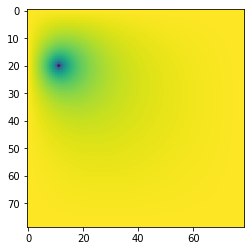

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(UU)
plt.show()

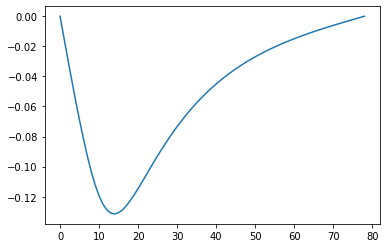

In [ ]:
plt.plot(UU[30,:])